In [26]:
# !pip install geopandas


In [27]:
# Import the MB data to geopandas

import geopandas as gpd

# Path to shapefile (relative to repository root since notebook is in notebooks/)
shapefile_path = "../data/raw/MB_2021_AUST_GDA2020.shp"

# Import the shapefile
gdf = gpd.read_file(shapefile_path)

# Check the first few rows
print(gdf.head())

     MB_CODE21     MB_CAT21 CHG_FLAG21  CHG_LBL21   SA1_CODE21 SA2_CODE21  \
0  10000010000  Residential          0  No change  10901117207  109011172   
1  10000021000   Commercial          0  No change  10901117612  109011176   
2  10000022000   Commercial          0  No change  10901117621  109011176   
3  10000023000   Commercial          0  No change  10901117621  109011176   
4  10000024000  Residential          0  No change  10901117613  109011176   

      SA2_NAME21 SA3_CODE21 SA3_NAME21 SA4_CODE21 SA4_NAME21 GCC_CODE21  \
0  Albury - East      10901     Albury        109     Murray      1RNSW   
1      Lavington      10901     Albury        109     Murray      1RNSW   
2      Lavington      10901     Albury        109     Murray      1RNSW   
3      Lavington      10901     Albury        109     Murray      1RNSW   
4      Lavington      10901     Albury        109     Murray      1RNSW   

    GCC_NAME21 STE_CODE21       STE_NAME21 AUS_CODE21 AUS_NAME21  AREASQKM21  \
0  Res

In [28]:
# 1. IDENTIFY WHICH MESH BLOCK CONTAINS YOUR PROPERTY
# Use spatial join to find the mesh block that contains the property point

property_meshblock = gpd.sjoin(
    property_gdf,
    gdf,
    how='left',
    predicate='within'
)

if not property_meshblock.empty and property_meshblock['MB_CODE21'].notna().any():
    mb_code = property_meshblock['MB_CODE21'].iloc[0]
    mb_name = property_meshblock['SA2_NAME21'].iloc[0]
    mb_state = property_meshblock['STE_NAME21'].iloc[0]
    
    print("=" * 60)
    print("✅ PROPERTY MESH BLOCK FOUND")
    print("=" * 60)
    print(f"Mesh Block Code: {mb_code}")
    print(f"Suburb/Area: {mb_name}")
    print(f"State: {mb_state}")
    print(f"Category: {property_meshblock['MB_CAT21'].iloc[0]}")
    print(f"Area (sq km): {property_meshblock['AREASQKM21'].iloc[0]}")
    
    # Get the full mesh block geometry
    my_meshblock = gdf[gdf['MB_CODE21'] == mb_code]
    print(f"\nMesh Block Details:")
    print(my_meshblock[['MB_CODE21', 'MB_CAT21', 'SA2_NAME21', 'SA3_NAME21', 'STE_NAME21']].to_string())
else:
    print("❌ Property not found in any mesh block")
    print("Check your coordinates or CRS projection")

✅ PROPERTY MESH BLOCK FOUND
Mesh Block Code: 20595390000
Suburb/Area: Vermont South
State: Victoria
Category: Residential
Area (sq km): 0.0437

Mesh Block Details:
          MB_CODE21     MB_CAT21     SA2_NAME21         SA3_NAME21 STE_NAME21
173794  20595390000  Residential  Vermont South  Whitehorse - East   Victoria


In [29]:
# 2. GET MESH BLOCKS WITHIN 2KM BOUNDING BOX

# Reproject to a metric CRS for accurate buffering (Australian Albers Equal Area)
property_metric = property_gdf.to_crs('EPSG:3577')  # GDA2020 Australian Albers
gdf_metric = gdf.to_crs('EPSG:3577')

# Create 2km buffer (2000 meters)
buffer_distance = 2000  # meters
property_buffer = property_metric.buffer(buffer_distance)

print("=" * 60)
print("🔍 FINDING MESH BLOCKS WITHIN 2KM")
print("=" * 60)
print(f"Buffer distance: {buffer_distance}m ({buffer_distance/1000}km)")

# Find mesh blocks that intersect with the 2km buffer
nearby_meshblocks = gdf_metric[gdf_metric.intersects(property_buffer.iloc[0])]

print(f"\n✅ Found {len(nearby_meshblocks)} mesh blocks within 2km")
print(f"\nSummary by category:")
print(nearby_meshblocks['MB_CAT21'].value_counts())

# Show first 10 nearby mesh blocks
print(f"\nFirst 10 nearby mesh blocks:")
print(nearby_meshblocks[['MB_CODE21', 'MB_CAT21', 'SA2_NAME21', 'AREASQKM21']].head(10).to_string(index=False))

🔍 FINDING MESH BLOCKS WITHIN 2KM
Buffer distance: 2000m (2.0km)

✅ Found 254 mesh blocks within 2km

Summary by category:
MB_CAT21
Residential    213
Parkland        25
Education       10
Commercial       5
Other            1
Name: count, dtype: int64

First 10 nearby mesh blocks:
  MB_CODE21    MB_CAT21           SA2_NAME21  AREASQKM21
20336700000    Parkland             Wantirna      1.2245
20430150000 Residential Glen Waverley - East      0.0307
20430210000 Residential Glen Waverley - East      0.0347
20430570000   Education Glen Waverley - East      0.0227
20430580000 Residential Glen Waverley - East      0.0315
20430590000 Residential Glen Waverley - East      0.0396
20430600000    Parkland Glen Waverley - East      0.0509
20430650000 Residential Glen Waverley - East      0.0400
20430700000 Residential Glen Waverley - East      0.0396
20431280000 Residential Glen Waverley - East      0.0317


In [30]:
# Example: Find mesh block for a property and get nearby mesh blocks
from shapely.geometry import Point
import geopandas as gpd
import json

# Load property coordinates from parcel.json
with open('../data/outputs/parcel.json', 'r') as f:
    parcel_data = json.load(f)

property_lon = parcel_data['coordinates']['longitude']
property_lat = parcel_data['coordinates']['latitude']
property_id = parcel_data['property_id']
property_address = parcel_data['address']

print(f"Loaded property from parcel.json:")
print(f"  Property ID: {property_id}")
print(f"  Address: {property_address}")
print(f"  Coordinates: ({property_lon}, {property_lat})")

# Create a point from your property coordinates
property_point = Point(property_lon, property_lat)

# Create a GeoDataFrame with the property point (WGS84 / EPSG:4326)
property_gdf = gpd.GeoDataFrame(
    {'property_id': [property_id], 'address': [property_address]},
    geometry=[property_point],
    crs='EPSG:4326'
)

print(f"\nProperty CRS: {property_gdf.crs}")
print(f"Mesh blocks CRS: {gdf.crs}")

# Ensure both are in the same CRS (reproject property to match mesh blocks)
property_gdf = property_gdf.to_crs(gdf.crs)
print(f"Property reprojected to: {property_gdf.crs}")

Loaded property from parcel.json:
  Property ID: 13683380
  Address: 5 Settlers Court Vermont South VIC 3133
  Coordinates: (145.18689565, -37.85878503)

Property CRS: EPSG:4326
Mesh blocks CRS: EPSG:7844
Property reprojected to: EPSG:7844



✅ Map saved

📊 MESH BLOCK CATEGORIES SUMMARY
Residential              : 213 blocks ( 83.9%)
Parkland                 :  25 blocks (  9.8%)
Education                :  10 blocks (  3.9%)
Commercial               :   5 blocks (  2.0%)
Other                    :   1 blocks (  0.4%)


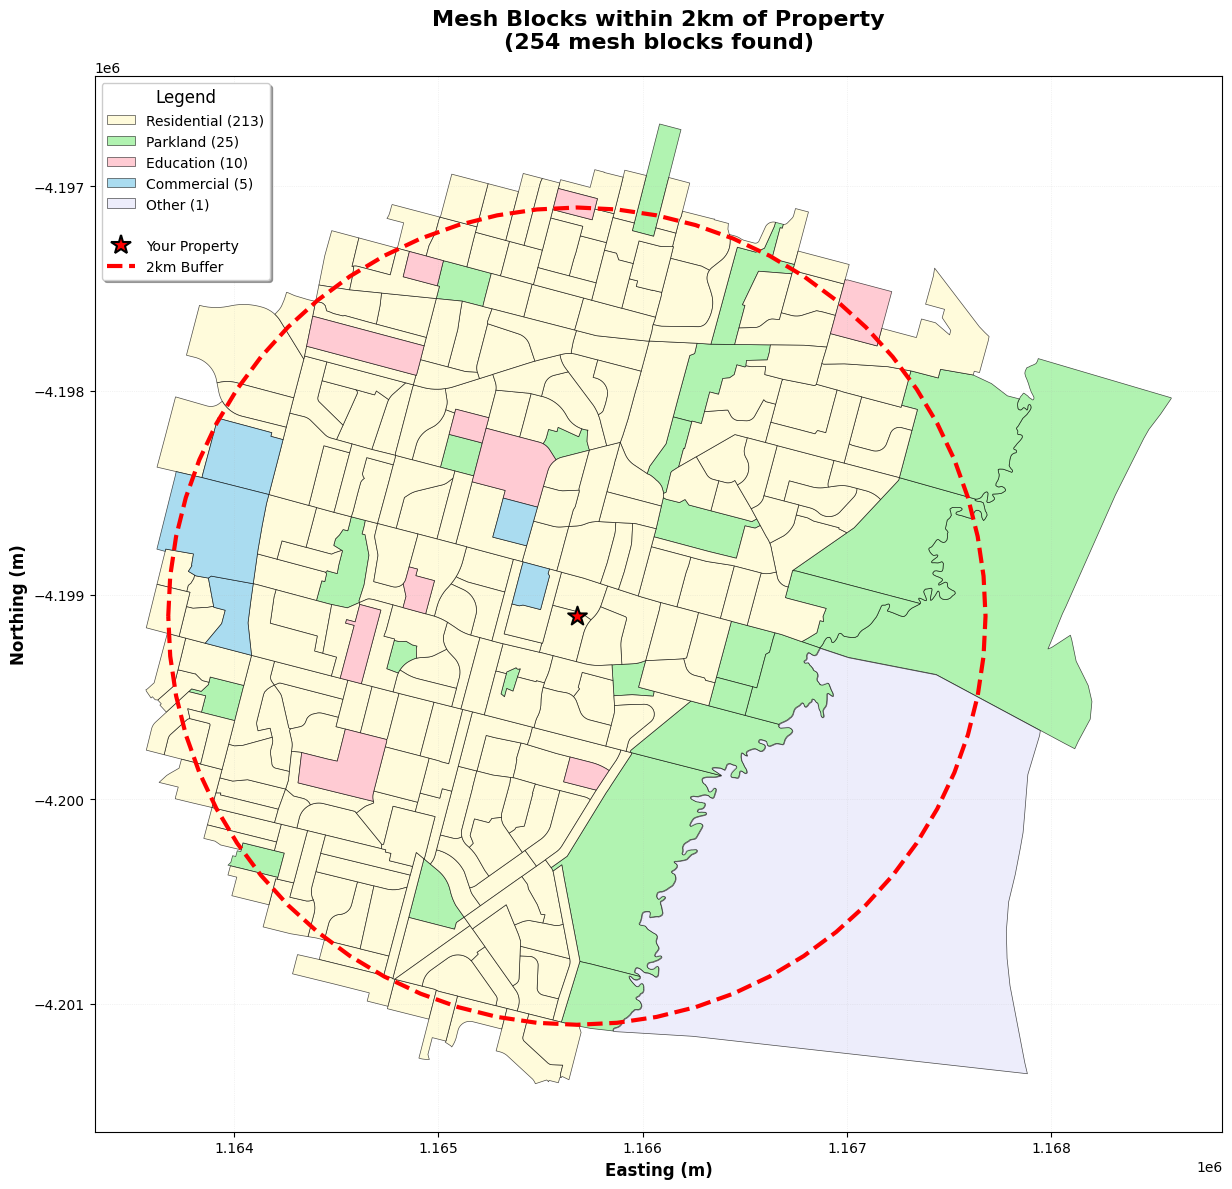

In [ ]:
## Vsiualise ##

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Define colors
category_colors = {
    'Residential': '#FFFACD', 'Commercial': '#87CEEB', 'Industrial': '#D3D3D3',
    'Parkland': '#90EE90', 'Primary Production': '#DEB887', 'Water': '#4682B4',
    'Education': '#FFB6C1', 'Hospital/Medical': '#FF69B4', 'Transport': '#FFA500',
    'Other': '#E6E6FA'
}

# Create plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot mesh blocks by category
for category in nearby_meshblocks['MB_CAT21'].unique():
    nearby_meshblocks[nearby_meshblocks['MB_CAT21'] == category].plot(
        ax=ax, color=category_colors.get(category, '#CCCCCC'),
        alpha=0.7, edgecolor='black', linewidth=0.5
    )

# Plot buffer and property
gpd.GeoDataFrame(geometry=property_buffer, crs='EPSG:3577').boundary.plot(
    ax=ax, color='red', linewidth=3, linestyle='--'
)
property_metric.plot(ax=ax, color='red', markersize=200, marker='*', 
                     edgecolor='black', linewidth=1.5, zorder=5)

# Configure plot
ax.set_title(f'Mesh Blocks within 2km of Property\n({len(nearby_meshblocks)} mesh blocks found)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Easting (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Northing (m)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# Create legend
category_counts = nearby_meshblocks['MB_CAT21'].value_counts()
legend_elements = [
    Patch(facecolor=category_colors.get(cat, '#CCCCCC'), edgecolor='black', 
          alpha=0.7, linewidth=0.5, label=f'{cat} ({count})')
    for cat, count in category_counts.items()
] + [
    Patch(facecolor='none', edgecolor='none', label=''),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='red', 
           markersize=15, markeredgecolor='black', markeredgewidth=1.5, label='Your Property'),
    Line2D([0], [0], color='red', linewidth=3, linestyle='--', label='2km Buffer')
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
          frameon=True, fancybox=True, shadow=True, title='Legend', title_fontsize=12)

# Save and display
plt.tight_layout()
plt.savefig("../data/outputs/meshblocks_map.png", dpi=200, bbox_inches='tight')
print(f"\n✅ Map saved\n\n{'='*60}\n📊 MESH BLOCK CATEGORIES SUMMARY\n{'='*60}")
for cat, count in category_counts.items():
    print(f"{cat:25s}: {count:3d} blocks ({count/len(nearby_meshblocks)*100:5.1f}%)")
plt.show()

In [32]:
# EXPORT RESULTS TO OUTPUTS FOLDER

print("=" * 60)
print("💾 EXPORTING RESULTS")
print("=" * 60)

# Convert back to WGS84 for standard output
nearby_meshblocks_wgs84 = nearby_meshblocks.to_crs('EPSG:4326')

# 1. Export to GeoJSON
output_geojson = "../data/outputs/meshblocks_within_2km.geojson"
nearby_meshblocks_wgs84.to_file(output_geojson, driver='GeoJSON')
print(f"✅ GeoJSON: {output_geojson}")

# 2. Export to CSV (attributes only)
output_csv = "../data/outputs/meshblocks_within_2km.csv"
nearby_meshblocks_wgs84.drop(columns='geometry').to_csv(output_csv, index=False)
print(f"✅ CSV: {output_csv}")

# 3. Export to Shapefile
output_shp = "../data/outputs/meshblocks_within_2km.shp"
nearby_meshblocks_wgs84.to_file(output_shp)
print(f"✅ Shapefile: {output_shp}")

# 4. Export just the mesh block codes to a simple text file
output_txt = "../data/outputs/meshblock_codes_2km.txt"
with open(output_txt, 'w') as f:
    f.write(f"Property Location: ({property_lon}, {property_lat})\n")
    f.write(f"Buffer Distance: {buffer_distance}m\n")
    f.write(f"Total Mesh Blocks Found: {len(nearby_meshblocks)}\n\n")
    f.write("Mesh Block Codes:\n")
    for code in nearby_meshblocks['MB_CODE21'].values:
        f.write(f"{code}\n")
print(f"✅ Text file: {output_txt}")

print(f"\n📊 Exported {len(nearby_meshblocks)} mesh blocks to outputs folder")

💾 EXPORTING RESULTS
✅ GeoJSON: ../data/outputs/meshblocks_within_2km.geojson
✅ CSV: ../data/outputs/meshblocks_within_2km.csv
✅ Shapefile: ../data/outputs/meshblocks_within_2km.shp
✅ Text file: ../data/outputs/meshblock_codes_2km.txt

📊 Exported 254 mesh blocks to outputs folder
